# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [102]:
import importlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

# %load_ext autoreload
# %autoreload 2

In [2]:
import dataset
import linear_classifer
import gradient_check
import metrics

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [4]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = dataset.load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = dataset.random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [52]:
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

gradient_check.check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

gradient_check.check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

gradient_check.check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]));

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [41]:
importlib.reload(linear_classifer)
importlib.reload(gradient_check)

# Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))
assert np.isclose(probs[2], 1.0, atol=1e-03)

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [42]:
importlib.reload(linear_classifer)
importlib.reload(gradient_check)

probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [53]:
importlib.reload(linear_classifer)
importlib.reload(gradient_check)

# Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
gradient_check.check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float));

Gradient check passed!


В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [44]:
importlib.reload(linear_classifer)
importlib.reload(gradient_check)

# Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)

# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
gradient_check.check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size)).astype(np.int)
gradient_check.check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [68]:
importlib.reload(linear_classifer)
importlib.reload(gradient_check)

# Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
gradient_check.check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W);

Gradient check passed!


### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [78]:
importlib.reload(linear_classifer)
importlib.reload(gradient_check)

# Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
gradient_check.check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W);

Gradient check passed!


# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [126]:
importlib.reload(linear_classifer)
importlib.reload(gradient_check)
importlib.reload(metrics)

classifier = linear_classifer.LinearSoftmaxClassifier()

fn_loss: 2.3014084007163764, reg_loss: 0.3062406480149124
fn_loss: 2.302389100907963, reg_loss: 0.29413821310872124
fn_loss: 2.301768573566575, reg_loss: 0.28249891509329433
fn_loss: 2.301049285370429, reg_loss: 0.2713301405377829
fn_loss: 2.301586487923539, reg_loss: 0.26061807409517185
fn_loss: 2.3012150612369524, reg_loss: 0.25031850000405487
fn_loss: 2.301507897114602, reg_loss: 0.24043479597131184
fn_loss: 2.3023218817210136, reg_loss: 0.23093916316171584
fn_loss: 2.300725485048325, reg_loss: 0.22180081539923432
fn_loss: 2.30244909582896, reg_loss: 0.21305754036069052
fn_loss: 2.301224019648883, reg_loss: 0.20462716967183442
fn_loss: 2.30116911814722, reg_loss: 0.19655331101037146
fn_loss: 2.301182070625474, reg_loss: 0.18879949695099943
fn_loss: 2.3014079859950773, reg_loss: 0.1813532160781646
fn_loss: 2.3008517322783226, reg_loss: 0.17419728899535383
fn_loss: 2.3014575405409583, reg_loss: 0.16733691992146707
fn_loss: 2.3019389994773625, reg_loss: 0.16073452072444355
fn_loss: 2.3

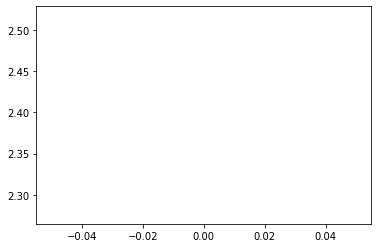

In [128]:
# Implement LinearSoftmaxClassifier.fit function
loss_history = classifier.fit(train_X, train_y, epochs=1, learning_rate=1e-3, batch_size=300, reg=1e1)
plt.plot(loss_history);

In [115]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = metrics.multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

Accuracy:  0.123


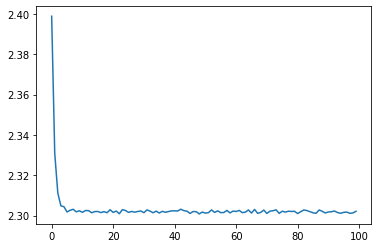

In [117]:
# Now, let's train more and see if it performs better
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
plt.plot(loss_history);

In [118]:
pred = classifier.predict(val_X)
accuracy = metrics.multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy after training for 100 epochs:  0.14


### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [110]:
np.logspace(-6, 1, num=8, base=10)
np.logspace(-6, 1, num=8, base=10)

array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])

In [111]:
num_epochs = 200
batch_size = 300

learning_rates = np.logspace(-6, 1, num=8, base=10)
reg_strengths = np.logspace(-6, 1, num=8, base=10)

df = pd.DataFrame(columns=learning_rates, index=reg_strengths)

for learning_rate in learning_rates:
    for reg_strength in reg_strengths:
        
        classifier = linear_classifer.LinearSoftmaxClassifier()
        classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)
        
        pred = classifier.predict(val_X)        
        accuracy = metrics.multiclass_accuracy(pred, val_y)
        
        df[learning_rate][reg_strength] = accuracy

In [112]:
df

,1e-06,1e-05,0.0001,0.001,0.01,0.1,1.0,10.0
0.000001,0.122,0.121,0.138,0.134,0.128,0.143,0.133,0.125
0.000010,0.121,0.118,0.128,0.12,0.124,0.122,0.119,0.116
0.000100,0.131,0.141,0.134,0.121,0.11,0.117,0.13,0.126
0.001000,0.124,0.128,0.134,0.119,0.145,0.117,0.131,0.126
0.010000,0.138,0.121,0.112,0.123,0.119,0.126,0.116,0.118
0.100000,0.128,0.124,0.117,0.138,0.116,0.122,0.137,0.128
1.000000,0.12,0.113,0.132,0.136,0.118,0.121,0.123,0.122
10.000000,0.121,0.142,0.125,0.123,0.131,0.124,0.122,0.125


In [ ]:
best_classifier = None
best_val_accuracy = None

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

print('best validation accuracy achieved: %f' % best_val_accuracy)

# Какой же точности мы добились на тестовых данных?

In [ ]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))